In [1]:
import sys
import os
root_dir = r'C:\Users\cg\Desktop\project\CardiacLab'
sys.path.append(os.path.join(root_dir, 'radiology'))

In [2]:
import os
from pathlib import PurePath
from functools import partial

import matplotlib.pyplot as plt

import torch

from monai.data import decollate_batch
from monai.transforms import (
    Compose,
    AddChanneld,
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    ScaleIntensityRanged,
    Spacingd,
    Orientationd,
    ToNumpyd,
    SqueezeDimd
)
from monai.inferers import sliding_window_inference, SlidingWindowInferer

from monailabel.transform.post import Restored
from networks.network import network

In [32]:
def infer(model, data, model_inferer, device):
    model.eval()
    with torch.no_grad():
        output = model_inferer(data['image'].to(device), model)
    return output


def run_infering(
        model,
        data,
        model_inferer,
        post_transforms,
        device
    ):
    data['pred'] = infer(model, data, model_inferer, device)
    data['pred'] = data['pred'][0]
    data = post_transforms(data)
    return data


def pre_transforms(target_spacing):
    return Compose([
        LoadImaged(keys="image"),
        AddChanneld(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys="image", pixdim=target_spacing, mode=("bilinear")),
        ScaleIntensityRanged(keys="image", a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        AddChanneld(keys=["image"])
    ])

def post_transforms():
    return Compose([
        EnsureTyped(keys="pred"),
        AsDiscreted(keys="pred", argmax=True),
        Orientationd(keys=["pred"], axcodes="LPS"),
        ToNumpyd(keys="pred"),
        Restored(keys="pred", ref_image="image"),
    ])



In [4]:
data_dict = {
    'image': os.path.join(root_dir, 'data/imagesTr/pid_1000.nii.gz')
}

In [5]:
data_dict

{'image': 'C:\\Users\\cg\\Desktop\\project\\CardiacLab\\data/imagesTr/pid_1000.nii.gz'}

In [6]:
data = pre_transforms([0.7,0.7,1.0])(data_dict)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [7]:
data['image'].shape

torch.Size([1, 1, 270, 270, 143])

In [33]:
# model
device = 'cuda'

model = network(
    'swinunetr',
    in_channels=1,
    out_channels=2
).to(device)

# check point
checkpoint_pth = os.path.join(root_dir, 'radiology/model/swinunetr/best_model.pth')
checkpoint = torch.load(checkpoint_pth)
model.load_state_dict(checkpoint["state_dict"])

# infer func
model_inferer = SlidingWindowInferer(
    roi_size=[96, 96, 96],
    sw_batch_size=2,
    overlap=0.25,
)

out = run_infering(
    model,
    data,
    model_inferer,
    post_transforms(),
    device
)

model: swinunetr


None of the inputs have requires_grad=True. Gradients will be None


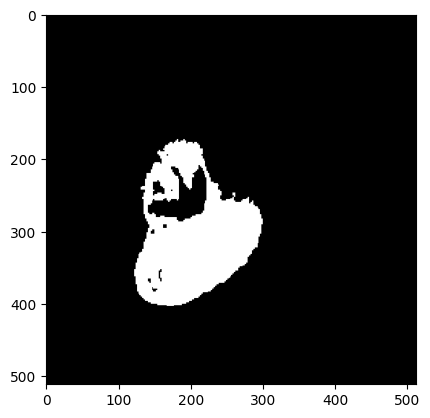

In [34]:
plt.imshow(out['pred'][:,:,80], cmap='gray')